In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from matplotlib import cm, colors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
path = "../processed/train/evaluated/paraphrase_humarin_samples_llama-2-7b_230_EVALUATED_05_12_2023.csv"
df = pd.read_csv(path)
df = df.drop(columns=['Unnamed: 0'])

In [6]:
df.columns

Index(['id', 'title', 'source', 'content', 'word-count',
       'content-actual-ending', 'content-to-sample', 'published',
       'kgw-watermarked', 'kthl-watermarked', 'non-watermarked', 'pp-kthl-1',
       'pp-kgw-1', 'pp-unwatermarked-1', 'pp-kthl-2', 'pp-kgw-2',
       'pp-unwatermarked-2', 'pp-kthl-3', 'pp-kgw-3', 'pp-unwatermarked-3',
       'kgw-wm-zscore', 'non-wm-zscore', 'kgw-wm-pp-zscore-1',
       'non-wm-pp-zscore-1', 'kgw-wm-pp-zscore-2', 'non-wm-pp-zscore-2',
       'kgw-wm-pp-zscore-3', 'non-wm-pp-zscore-3'],
      dtype='object')

In [11]:
image_output_path = "../results/images/confusion_matrices/llama-2-7b-december/"
z_threshold = 4.0
# Need to binary classify the results 

In [24]:
relevant_columns = ["id", "kgw-watermarked", "kgw-wm-zscore"]

In [25]:
base_wmark_df = df[relevant_columns].copy()
base_wmark_df["watermarked"] = [True for _ in range(len(base_wmark_df))]
base_wmark_df = base_wmark_df.rename(columns={"kgw-watermarked": "text", "kgw-wm-zscore": "z-score"})

non_wmark_df = df[["non-watermarked", "non-wm-zscore"]].copy()
non_wmark_df["watermarked"] = [False for _ in range(len(non_wmark_df))]
non_wmark_df = non_wmark_df.rename(columns={"non-watermarked": "text", "non-wm-zscore": "z-score"})

In [26]:
bc_df = pd.concat([base_wmark_df, non_wmark_df])
bc_df['watermark-detected'] = bc_df.apply(lambda x: x['z-score'] > z_threshold, axis=1)

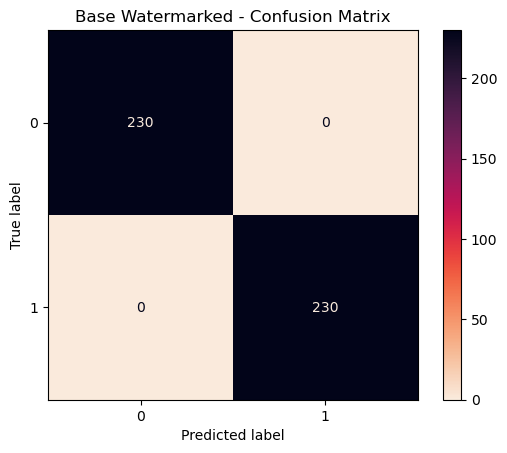

In [27]:
cf = confusion_matrix(bc_df["watermarked"], bc_df["watermark-detected"])
disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot(cmap=sns.color_palette("rocket_r", as_cmap=True), colorbar=True)
plt.title(f"Base Watermarked - Confusion Matrix")
# plt.savefig(image_output_path+f"base_watermarked.png")
plt.show()

In [28]:
def gen_paraphrase_df(full_df, pp_iter = 1, z_threshold = 4.0):
    wmark_df = full_df[["id", f"pp-kgw-{pp_iter}", f"kgw-wm-pp-zscore-{pp_iter}"]]
    wmark_df = wmark_df.rename(columns={f"pp-kgw-{pp_iter}": "text", f"kgw-wm-pp-zscore-{pp_iter}": "z-score"})
    wmark_df["watermarked"] = [True for _ in range(len(wmark_df))]
    
    nwmark_df = full_df[["id", f"pp-unwatermarked-{pp_iter}", f"non-wm-pp-zscore-{pp_iter}"]]
    nwmark_df = nwmark_df.rename(columns={f"pp-unwatermarked-{pp_iter}": "text", f"non-wm-pp-zscore-{pp_iter}": "z-score"})
    nwmark_df["watermarked"] = [False for _ in range(len(nwmark_df))]
    
    bc_df = pd.concat([wmark_df, nwmark_df])
    bc_df["watermark-detected"] = bc_df.apply(lambda x: x['z-score'] > z_threshold, axis=1)
    return bc_df

In [51]:
def get_fn_ids(pp_df):
    return list(pp_df[np.logical_and(pp_df["watermarked"] == True, pp_df["watermark-detected"] == False)]["id"])

In [50]:
def get_tp_ids(pp_df):
    return list(pp_df[np.logical_and(pp_df["watermarked"] == True, pp_df["watermark-detected"] == True)]["id"])

In [ ]:
def plot_image(conf_matrix):
    
    ax = sns.heatmap(cosine_scores, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
    ax.set_ylabel("Text Group")
    ax.set_xlabel("Text Group")
    ax.set_title("Sentence Similarity between Recursive Paraphrases")
    
    if save:
        if save_location == None:
            raise "Save location must be defined if saving"
        plt.savefig(save_location)
    plt.show()

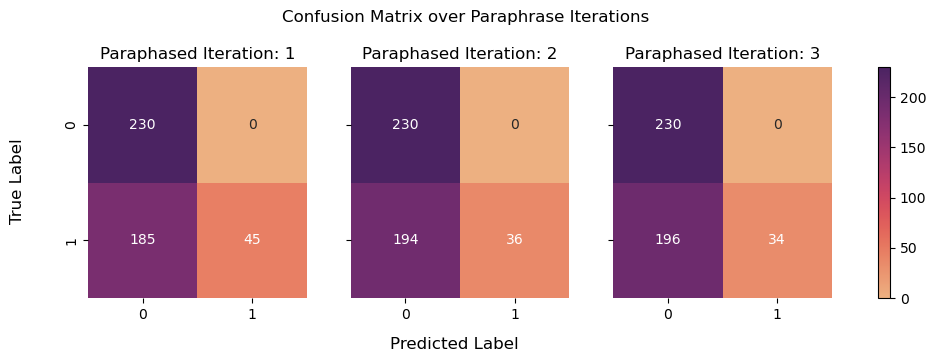

In [205]:
fig, axs = plt.subplots(1,3, figsize=(12, 3), sharey=True)
c_cmap = sns.color_palette("flare", as_cmap=True)
norm = colors.Normalize(vmin=0, vmax=230)
for i in range(1,4):
    pp_bc_df = gen_paraphrase_df(df, pp_iter=i)
    cf = confusion_matrix(pp_bc_df["watermarked"], pp_bc_df["watermark-detected"])
    hm = sns.heatmap(cf, annot=True, fmt=".0f",ax=axs[i-1], cmap=c_cmap, vmin=0, vmax=230, cbar=False)
    axs[i-1].set_title(f"Paraphased Iteration: {i}")

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=c_cmap), ax=axs.ravel().tolist())
fig.supxlabel("Predicted Label", x=0.43, y=-0.07)
fig.supylabel("True Label", x=0.06)
fig.suptitle("Confusion Matrix over Paraphrase Iterations", y=1.07, x=0.44)
# plt.savefig(image_output_path+f"combined_iterations.png", bbox_inches='tight')
plt.show()

In [52]:
fn_ids = [] 
tp_ids = []
for i in range(1,4):
    pp_bc_df = gen_paraphrase_df(df, pp_iter=i)
    fn_ids.append(get_fn_ids(pp_bc_df))
    tp_ids.append(get_tp_ids(pp_bc_df))

In [93]:
unique_ids = list({id for row in tp_ids for id in row})
data = np.array([[id in tp_ids[i] for id in unique_ids] for i in range(3)])
data_r = data.swapaxes(0,1)

In [97]:
presence_df = pd.DataFrame(data_r, columns=["Present in PP_1", "Present in PP_2", "Present in PP_2"])
presence_df.insert(0, "id", unique_ids)

## Documents becoming watermarked after repeated paraphrase

In [206]:
in_3_in_1 = len([id for id in tp_ids[2] if id in tp_ids[0] and id in tp_ids[1]])
final_in_first = in_3_in_1 / len(tp_ids[2])

In [207]:
final_in_first

0.8529411764705882

In [101]:
presence_df

,id,Present in PP_1,Present in PP_2,Present in PP_2
0,b66efefe-1060-4659-99d5-557b80c70f50,True,True,True
1,1dabda84-be39-4e7b-a55c-6bcd369b355e,True,True,True
2,20e52a88-6ed0-4497-9e4a-68edd9b1ecc3,True,True,True
3,90a7960a-2a57-49db-b057-b600c159f15e,True,False,False
4,52633a63-42f9-4bc9-ae32-a99108104512,True,True,False
5,ded8ad9c-eb80-44bd-a083-9f4213b0cc90,True,True,True
6,d3a9e9c8-d41e-4e30-9cfe-dc3c84ccfd61,True,True,True
7,4804c484-8415-40cd-b6fa-c1e1222cc664,True,True,True
8,48c48c05-b795-43fa-b31a-44f37db6a24d,True,False,True
9,5319cdad-29b2-401b-93e8-4d6a459f2d88,True,True,True
